# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early!


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# Preliminaries

In [ ]:
!nvidia-smi # to see what GPU you have

In [ ]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [2]:
%load_ext autoreload
%autoreload 2
import torch
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
from torch import nn
from siamese_net import *
from convnext import *
from mobilenet import *
from efficientnet import *

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device:  cuda


In [ ]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive


# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2

In [ ]:
!mkdir '/content/data'

!kaggle competitions download -c 11-785-f23-hw2p2-classification
!unzip -qo '11-785-f23-hw2p2-classification.zip' -d '/content/data'

!kaggle competitions download -c 11-785-f23-hw2p2-verification
!unzip -qo '11-785-f23-hw2p2-verification.zip' -d '/content/data'

# Configs

In [2]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.05,
    'epochs': 40, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Classification Dataset

In [3]:
DATA_DIR    = 'data/11-785-f23-hw2p2-classification'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 0,
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 0
)

In [4]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [5]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 0)

In [6]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  2188
Val batches          :  547


## Data visualization

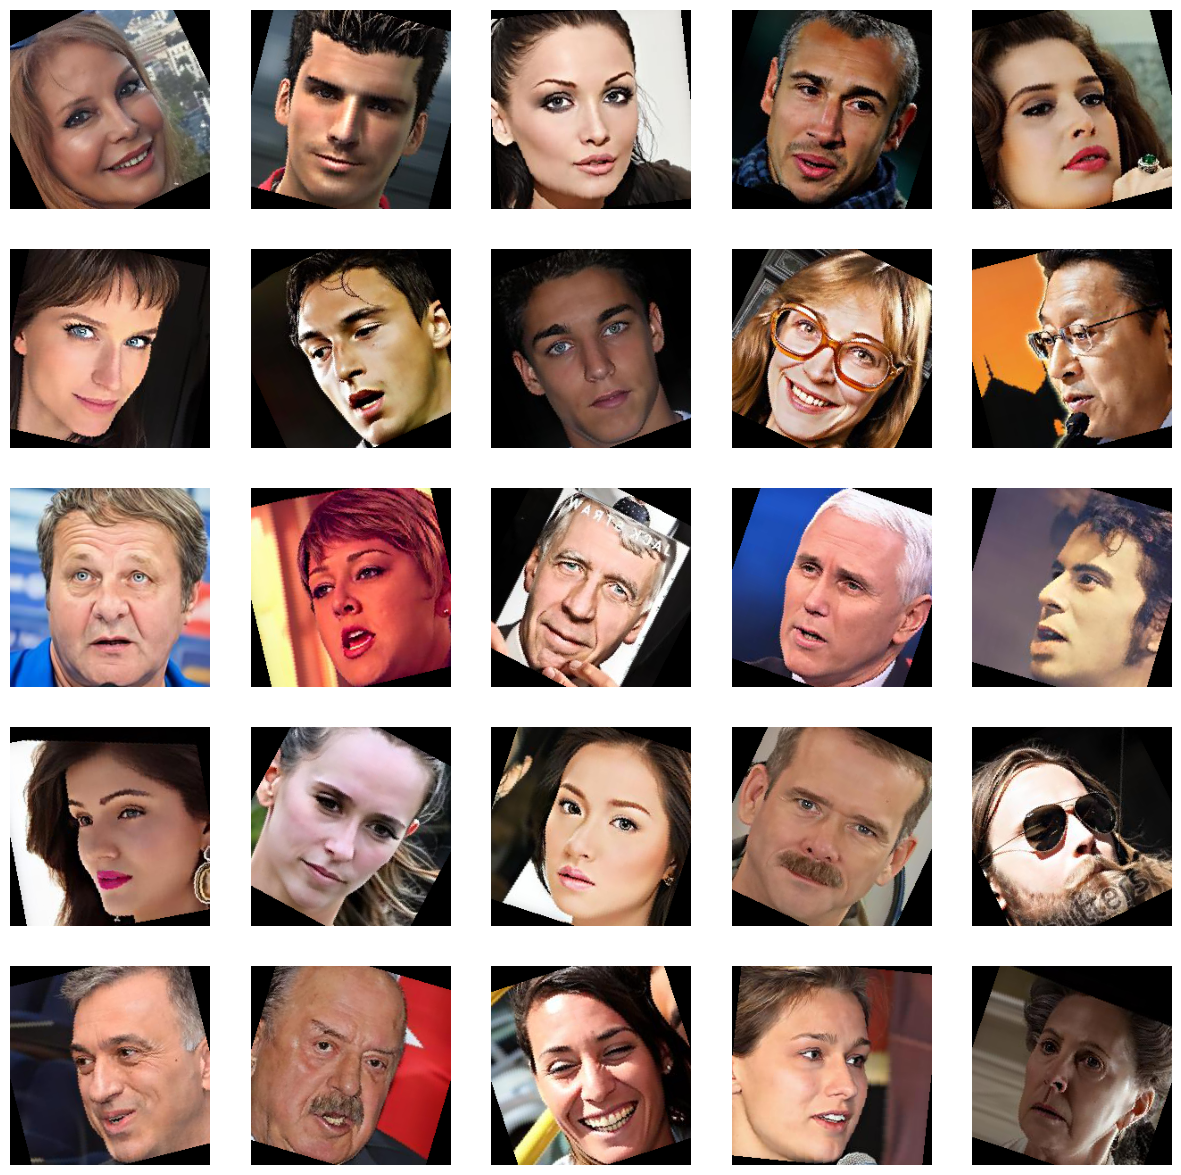

In [12]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [ ]:
class Network(torch.nn.Module):
    """
    The Very Low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 21M.

    The first Conv layer has 64 channels, kernel size 7, and stride 4.
    The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2.

    Think about strided convolutions from the lecture, as convolutioin with stride= 1 and downsampling.
    For stride 1 convolution, what padding do you need for preserving the spatial resolution?
    (Hint => padding = kernel_size // 2) - Why?)

    Each Conv layer is accompanied by a Batchnorm and ReLU layer.
    Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d.
    Then, remove (Flatten?) these trivial 1x1 dimensions away.
    Look through https://pytorch.org/docs/stable/nn.html

    TODO: Fill out the model definition below!

    Why does a very simple network have 4 convolutions?
    Input images are 224x224. Note that each of these convolutions downsample.
    Downsampling 2x effectively doubles the receptive field, increasing the spatial
    region each pixel extracts features from. Downsampling 32x is standard
    for most image models.

    Why does a very simple network have high channel sizes?
    Every time you downsample 2x, you do 4x less computation (at same channel size).
    To maintain the same level of computation, you 2x increase # of channels, which
    increases computation by 4x. So, balances out to same computation.
    Another intuition is - as you downsample, you lose spatial information. We want
    to preserve some of it in the channel dimension.
    """

    def __init__(self, num_classes=7001):
        model = torchvision.models.convnext_base(pretrained = True)
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.ReLU(),
            BasicBlock(32, 64),
            BasicBlock(64, 128),
            BasicBlock(128, 256),
            BasicBlock(256, 512),
            nn.AdaptiveAvgPool2d(output_size=(7, 7))
        )
        
        # if using centerloss
        # self.feat_layer = nn.Sequential(
        #     nn.Linear(25088, 4096),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(4096, 1024),
        # )
        
        # self.cls_layer = nn.Sequential(
        #     nn.Linear(1024, 2048),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(2048, num_classes)
        # )
        #
        
        # if not using centerloss
        self.cls_layer = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        #
    def forward(self, x, return_feats=False):
        """
        What is return_feats? It essentially returns the second-to-last-layer
        features of a given image. It's a "feature encoding" of the input image,
        and you can use it for the verification task. You would use the outputs
        of the final classification layer for the classification task.

        You might also find that the classification outputs are sometimes better
        for verification too - try both.
        """
        
        # if using centerloss
        # feats = self.backbone(x)
        # feats = feats.flatten(1)
        # feats = self.feat_layer(feats)
        # out_logits = self.cls_layer(feats)
        # if not using centerloss
        feats = self.backbone(x)
        feats = feats.flatten(1)
        out_logits = self.cls_layer(feats)

        if return_feats:
            return feats, out_logits
        else:
            return out_logits
        
model = Network().to(DEVICE)
# summary(model, (3, 224, 224))

In [6]:
# mobilenet
# model = MobileNetV2().to(DEVICE)
# efficientnet
model = EfficientNet().to(DEVICE)

In [10]:
print(sum([param.numel() for param in model.parameters()]))
for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    logits = model(images)
    break

5468585


# Setup everything for training

In [7]:
criterion = torch.nn.CrossEntropyLoss()# TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 7, 0.7)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

/tmp/ipykernel_1325411/1923817465.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you


# Let's train!

In [8]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    scheduler.step()
    
    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [9]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [10]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [11]:
wandb.login(key="1d70da927fe2f85af2f2aa8e4861950d6f63844e") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: khjune29 (cvl2023) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [12]:
# Create your wandb run
run = wandb.init(
    name = "efficientnet-verification", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


# Experiments

In [13]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)

    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, './checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
    #   You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()

Train:   0%|          | 0/4376 [00:00<?, ?it/s]

/tmp/ipykernel_1325411/1747391588.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!



Epoch 1/40: 
Train Acc 0.2135%	 Train Loss 8.2963	 Learning Rate 0.0500


Val Acc 0.7598%	 Val Loss 7.4107
Saving model



Epoch 2/40: 
Train Acc 1.6518%	 Train Loss 6.9079	 Learning Rate 0.0500


Val Acc 3.1364%	 Val Loss 6.3346
Saving model



Epoch 3/40: 
Train Acc 4.8725%	 Train Loss 6.0130	 Learning Rate 0.0500


Val Acc 7.6297%	 Val Loss 5.5797
Saving model



Epoch 4/40: 
Train Acc 9.1979%	 Train Loss 5.3895	 Learning Rate 0.0500


Val Acc 13.2713%	 Val Loss 4.9854
Saving model



Epoch 5/40: 
Train Acc 14.2360%	 Train Loss 4.8816	 Learning Rate 0.0500


Val Acc 19.2785%	 Val Loss 4.4904
Saving model



Epoch 6/40: 
Train Acc 18.8657%	 Train Loss 4.4795	 Learning Rate 0.0500


Val Acc 23.3061%	 Val Loss 4.2050
Saving model



Epoch 7/40: 
Train Acc 22.9469%	 Train Loss 4.1902	 Learning Rate 0.0500


Val Acc 27.2623%	 Val Loss 3.9013
Saving model



Epoch 8/40: 
Train Acc 31.4878%	 Train Loss 3.6192	 Learning Rate 0.0350


Val Acc 36.8601%	 Val Loss 3.3294
Saving model



Epoch 9/40: 
Train Acc 33.8637%	 Train Loss 3.4686	 Learning Rate 0.0350


Val Acc 38.5940%	 Val Loss 3.2385
Saving model



Epoch 10/40: 
Train Acc 35.5833%	 Train Loss 3.3575	 Learning Rate 0.0350


Val Acc 38.6197%	 Val Loss 3.2333
Saving model



Epoch 11/40: 
Train Acc 37.4272%	 Train Loss 3.2441	 Learning Rate 0.0350


Val Acc 41.7762%	 Val Loss 3.0365
Saving model



Epoch 12/40: 
Train Acc 39.1496%	 Train Loss 3.1398	 Learning Rate 0.0350


Val Acc 44.4527%	 Val Loss 2.8828
Saving model



Epoch 13/40: 
Train Acc 40.8749%	 Train Loss 3.0377	 Learning Rate 0.0350


Val Acc 45.4867%	 Val Loss 2.8251
Saving model



Epoch 14/40: 
Train Acc 42.2175%	 Train Loss 2.9515	 Learning Rate 0.0350


Val Acc 46.4180%	 Val Loss 2.7886
Saving model



Epoch 15/40: 
Train Acc 50.1328%	 Train Loss 2.5326	 Learning Rate 0.0245


Val Acc 55.8301%	 Val Loss 2.2955
Saving model



Epoch 16/40: 
Train Acc 51.0019%	 Train Loss 2.4741	 Learning Rate 0.0245


Val Acc 54.7475%	 Val Loss 2.3495



Epoch 17/40: 
Train Acc 51.8460%	 Train Loss 2.4303	 Learning Rate 0.0245


Val Acc 56.4071%	 Val Loss 2.2729
Saving model



Epoch 18/40: 
Train Acc 52.3666%	 Train Loss 2.3942	 Learning Rate 0.0245


Val Acc 55.9901%	 Val Loss 2.2824



Epoch 19/40: 
Train Acc 52.9979%	 Train Loss 2.3582	 Learning Rate 0.0245


Val Acc 56.5299%	 Val Loss 2.2580
Saving model



Epoch 20/40: 
Train Acc 53.6670%	 Train Loss 2.3294	 Learning Rate 0.0245


Val Acc 56.3014%	 Val Loss 2.2661



Epoch 21/40: 
Train Acc 54.1669%	 Train Loss 2.2922	 Learning Rate 0.0245


Val Acc 56.9955%	 Val Loss 2.2404
Saving model



Epoch 22/40: 
Train Acc 60.8582%	 Train Loss 1.9666	 Learning Rate 0.0171


Val Acc 63.1170%	 Val Loss 1.9478
Saving model



Epoch 23/40: 
Train Acc 61.2003%	 Train Loss 1.9345	 Learning Rate 0.0171


Val Acc 63.9425%	 Val Loss 1.8947
Saving model



Epoch 24/40: 
Train Acc 60.9589%	 Train Loss 1.9310	 Learning Rate 0.0171


Val Acc 63.5226%	 Val Loss 1.8963



Epoch 25/40: 
Train Acc 61.2224%	 Train Loss 1.9186	 Learning Rate 0.0171


Val Acc 62.9827%	 Val Loss 1.9295



Epoch 26/40: 
Train Acc 61.3117%	 Train Loss 1.9068	 Learning Rate 0.0171


Val Acc 62.9428%	 Val Loss 1.9455



Epoch 27/40: 
Train Acc 61.4374%	 Train Loss 1.8930	 Learning Rate 0.0171


Val Acc 64.0454%	 Val Loss 1.9014
Saving model



Epoch 28/40: 
Train Acc 61.8052%	 Train Loss 1.8800	 Learning Rate 0.0171


Val Acc 64.0739%	 Val Loss 1.8736
Saving model



Epoch 29/40: 
Train Acc 67.4246%	 Train Loss 1.6122	 Learning Rate 0.0120


Val Acc 69.2156%	 Val Loss 1.6470
Saving model



Epoch 30/40: 
Train Acc 67.9737%	 Train Loss 1.5776	 Learning Rate 0.0120


Val Acc 68.8500%	 Val Loss 1.6726



Epoch 31/40: 
Train Acc 67.9816%	 Train Loss 1.5734	 Learning Rate 0.0120


Val Acc 68.2415%	 Val Loss 1.6803



Epoch 32/40: 
Train Acc 67.7588%	 Train Loss 1.5690	 Learning Rate 0.0120


Val Acc 68.2016%	 Val Loss 1.6909



Epoch 33/40: 
Train Acc 68.0237%	 Train Loss 1.5618	 Learning Rate 0.0120


Val Acc 68.4044%	 Val Loss 1.6868



Epoch 34/40: 
Train Acc 68.0130%	 Train Loss 1.5527	 Learning Rate 0.0120


Val Acc 68.7729%	 Val Loss 1.6782



Epoch 35/40: 
Train Acc 68.1608%	 Train Loss 1.5514	 Learning Rate 0.0120


Val Acc 68.0930%	 Val Loss 1.6887



Epoch 36/40: 
Train Acc 72.6941%	 Train Loss 1.3387	 Learning Rate 0.0084


Val Acc 72.1578%	 Val Loss 1.5056
Saving model



Epoch 37/40: 
Train Acc 73.0769%	 Train Loss 1.3119	 Learning Rate 0.0084


Val Acc 71.5579%	 Val Loss 1.5341



Epoch 38/40: 
Train Acc 73.1211%	 Train Loss 1.3103	 Learning Rate 0.0084


Val Acc 71.9778%	 Val Loss 1.5172



Epoch 39/40: 
Train Acc 73.1283%	 Train Loss 1.3036	 Learning Rate 0.0084


Val Acc 71.8693%	 Val Loss 1.5125



Epoch 40/40: 
Train Acc 72.9855%	 Train Loss 1.3063	 Learning Rate 0.0084


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Val Acc 71.3637%	 Val Loss 1.5481


learning_Rate,███████▅▅▅▅▅▅▅▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_Acc,▁▁▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇████████
train_loss,█▇▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_Acc,▁▁▂▂▃▃▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
validation_loss,█▇▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,0.0084
train_Acc,72.98546
train_loss,1.30635
validation_Acc,71.36369
validation_loss,1.54807


# Classification Task: Testing

In [14]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [15]:
test_results = test(model, test_loader)

Test:   0%|          | 0/547 [00:00<?, ?it/s]

## Generate csv to submit to Kaggle

In [16]:
with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

In [17]:
!kaggle competitions submit -c 11-785-f23-hw2p2-classification -f classification_early_submission.csv -m "early submission"

100%|█████████████████████████████████████████| 542k/542k [00:00<00:00, 621kB/s]
Successfully submitted to Face Recognition

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [6]:
# mobilenet
# model = MobileNetV2(num_classes=7001).cuda()
# efficientNet
model = EfficientNet().cuda()

In [7]:
# This obtains the list of known identities from the known folder
known_regex = "data/11-785-f23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "data/11-785-f23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "data/11-785-f23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
# similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)
def similarity_metric(x, y):
    #return F.cosine_similarity(x, y)
    return (x-y).square().mean(-1)

  0%|          | 0/960 [00:00<?, ?it/s]

100%|██████████| 960/960 [00:00<00:00, 10007.24it/s]


In [8]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat, _ = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat, _ = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.min(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])

    accuracy = 0.0
    if mode == 'val':
      true_ids = pd.read_csv('data/11-785-f23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))

    return accuracy, pred_id_strings

In [9]:
# verification eval
acc, pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
acc, pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")


Verification Accuracy = 0.002777777777777778


In [25]:
sum([param.numel() for param in model.parameters()])

136330073

In [18]:
center_loss_module = CenterLoss(embed_dim=512).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()# TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.SGD(list(model.parameters())+list(center_loss_module.parameters()), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 7, 0.7)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

/tmp/ipykernel_1397395/2804981028.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you


In [19]:
# add your finetune/retrain code here
# model = Network().to(DEVICE)
def train(model, dataloader, optimizer, criterion):
    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0
    total_cls_loss      = 0
    total_center_loss   = 0
    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            features, outputs = model(images, return_feats=True)
            center_loss = center_loss_module(features, labels)
            cls_loss = criterion(outputs, labels)
            loss = cls_loss + 0.01*center_loss

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())
        total_cls_loss  += float(cls_loss.item())
        total_center_loss += float(center_loss.item())
        
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            cls_loss    = "{:.04f}".format(float(total_cls_loss / (i + 1))),
            center_loss = "{:.04f}".format(float(total_center_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    scheduler.step()
    
    batch_bar.close() # You need this to close the tqdm bar
    
    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))
    total_center_loss = float(total_center_loss / len(dataloader))
    return acc, total_loss, total_center_loss

In [20]:
# training loop with validation
for epoch in range(config['epochs']):
    train_acc, train_loss, center_loss = train(model, train_loader, optimizer, criterion)
    val_acc, _ = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
    # wandb.log({
    #     "train_Acc" : train_acc,
    #     "train_loss": train_loss,
    #     "center_loss": center_loss,
    #     "verification_Acc": val_acc,
    # })
## Generate csv to submit to Kaggle

Train:   0%|          | 0/2188 [00:00<?, ?it/s]

/tmp/ipykernel_1397395/1766139130.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")


Verification Accuracy = 0.0


Train:   0%|          | 0/2188 [00:00<?, ?it/s]/tmp/ipykernel_1397395/1766139130.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")


Verification Accuracy = 0.011111111111111112


Train:   0%|          | 0/2188 [00:00<?, ?it/s]/tmp/ipykernel_1397395/1766139130.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")


Verification Accuracy = 0.022222222222222223


Train:   0%|          | 0/2188 [00:00<?, ?it/s]/tmp/ipykernel_1397395/1766139130.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!


KeyboardInterrupt: 

In [21]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [22]:
!kaggle competitions submit -c 11-785-f23-hw2p2-verification -f verification_early_submission.csv -m "early submission"

100%|██████████████████████████████████████| 8.34k/8.34k [00:00<00:00, 21.0kB/s]
Successfully submitted to Face Verification